In [1]:
%load_ext jupyter_black

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import (
    SelectKBest,
    f_classif,
    chi2,
    mutual_info_classif,
    VarianceThreshold,
    SequentialFeatureSelector,
)


import matplotlib.pyplot as plt
import seaborn as sns

target_palette = {"Graduate": "#4ECDC4", "Dropout": "#FF6B6B"}

In [3]:
train = pd.read_parquet("../data/splits/train.parquet")

In [4]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
application_order,3539.0,1.720825,1.307475,0.00,1.00,1.000000,2.00000,9.000000
age_at_enrollment,3539.0,23.192992,7.423040,17.00,19.00,20.000000,25.00000,62.000000
first_sem_credited,3539.0,0.688613,2.288594,0.00,0.00,0.000000,0.00000,20.000000
first_sem_enrolled,3539.0,6.238203,2.433641,0.00,5.00,6.000000,7.00000,26.000000
first_sem_evaluations,3539.0,8.238485,4.155428,0.00,6.00,8.000000,10.00000,45.000000
first_sem_approved,3539.0,4.677310,3.057832,0.00,3.00,5.000000,6.00000,26.000000
first_sem_grade,3539.0,10.616223,4.882002,0.00,11.00,12.333333,13.40000,18.000000
first_sem_without_evaluations,3539.0,0.137609,0.684972,0.00,0.00,0.000000,0.00000,12.000000
second_sem_credited,3539.0,0.526137,1.869872,0.00,0.00,0.000000,0.00000,19.000000
second_sem_enrolled,3539.0,6.203165,2.163140,0.00,5.00,6.000000,7.00000,23.000000


In [5]:
# This column has low variance, I will drop it
train.nationality.value_counts()

Portuguese               3455
Brazilian                  29
Santomean                  10
Spanish                    10
Cape Verdean               10
Italian                     3
Ukrainian                   3
Guinean                     3
Mexican                     2
Angolan                     2
Romanian                    2
Moldova (Republic of)       2
Mozambican                  2
English                     1
Colombian                   1
Dutch                       1
Lithuanian                  1
Russian                     1
German                      1
Name: nationality, dtype: int64

In [6]:
# This column also has low variance, I will drop it also. There is no difference in the outcome in what we saw in the EDA step
train.international.value_counts()

no     3455
yes      84
Name: international, dtype: int64

In [7]:
# Probably the best is to group together rare categories (less than 50 students?)
train.application_mode.value_counts()

1st phase - general contingent                         1384
2nd phase - general contingent                          681
Over 23 years old                                       620
Change of course                                        252
Technological specialization diploma holders            174
Holders of other higher courses                         111
3rd phase - general contingent                          102
Transfer                                                 64
Change of institution/course                             48
1st phase - special contingent (Madeira Island)          28
Short cycle diploma holders                              26
International student (bachelor)                         24
1st phase - special contingent (Azores Island)           15
Ordinance No. 854-B/99                                    6
Ordinance No. 533-A/99, item b2) (Different Plan)         1
Change of institution/course (International)              1
Ordinance No. 612/93                    

In [8]:
def feat_eng_1(df):
    df = df.copy()
    # Create a column of percentage of exams approved
    df = df.assign(
        # Number of approved units over total number of evaluations (its not a percentage of approved exams)
        first_sem_approved_over_evaluations=lambda x: x.first_sem_approved
        / x.first_sem_evaluations,
        second_sem_approved_over_evaluations=lambda x: x.second_sem_approved
        / x.second_sem_evaluations,
        # There are some students with 0 evaluations in the semesters, the coefficient will be np.nan value.
        # I will fill these with the mean value and create a boolean flag
        first_sem_has_evals=lambda x: x.first_sem_evaluations != 0,
        second_sem_has_evals=lambda x: x.second_sem_evaluations != 0,
        # Boolean flag for sem_without_evaluations predictors
        first_sem_has_units_without_evals=lambda x: x.first_sem_without_evaluations
        == 0,
        second_sem_has_units_without_evals=lambda x: x.second_sem_without_evaluations
        == 0,
        # Ratio of average grade over number of enrolled units
        first_sem_grade_over_enrolled=lambda x: x.first_sem_grade
        / x.first_sem_enrolled,
        second_sem_grade_over_enrolled=lambda x: x.second_sem_grade
        / x.second_sem_enrolled,
        # Again, there are some students with 0 enrolled units in the semesters, the coefficient will be np.nan value.
        # I will fill these with the mean value and create a boolean flag
        first_sem_has_enrolled=lambda x: x.first_sem_enrolled != 0,
        second_sem_has_enrolled=lambda x: x.second_sem_enrolled != 0,
        # Number of disapproved units
        first_sem_disapproved=lambda x: x.first_sem_enrolled - x.first_sem_approved,
        second_sem_disapproved=lambda x: x.second_sem_enrolled - x.second_sem_approved,
        # Percentage of units credited over enrolled
        first_sem_perc_credited=lambda x: x.first_sem_credited / x.first_sem_enrolled,
        second_sem_perc_credited=lambda x: x.second_sem_credited
        / x.second_sem_enrolled,
    )
    df = df.drop(columns=["nationality", "international"])
    return df

In [67]:
train_fe = train.pipe(feat_eng_1)
X_fe = train_fe.drop(columns=["dropout"])
y = train_fe["dropout"]

In [62]:
X_fe.shape[1]

46

Before starting the different feature selection methods, I will create a dictionary to store the features selected by each method

In [13]:
features_selected = {}

### Variance Threshold analysis

Variance Threshold is a simple baseline approach to feature selection. It removes all features whose variance doesn’t meet some threshold.

In [63]:
threshold = 0.3

categorical_transformer = ColumnTransformer(
    [
        (
            "ordinal_encoder",
            OrdinalEncoder(),
            X_fe.select_dtypes(exclude="number").columns.values,
        )
    ],
    remainder="passthrough",
    verbose_feature_names_out=False,
)

variance_threshold_pipe = make_pipeline(
    categorical_transformer, VarianceThreshold(threshold)
)
variance_threshold_pipe.fit(X_fe)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ordinal_encoder',
                                                  OrdinalEncoder(),
                                                  array(['marital_status', 'application_mode', 'course', 'day_evening',
       'previous_education', 'mother_education', 'father_education',
       'mother_occupation', 'father_occupation', 'displaced',
       'special_needs', 'debtor', 'tuition_fees_up_to_date', 'gender',
       'scholarship_holder', 'first_sem_has_evals',
       'second_sem_has_evals', 'first_sem_has_units_without_evals',
       'second_sem_has_units_without_evals', 'first_sem_has_enrolled',
       'second_sem_has_enrolled'], dtype=object))],
                                   verbose_feature_names_out=False)),
                ('variancethreshold', VarianceThreshold(threshold=0.3))])

In [64]:
features_selected[
    "variance_threshold"
] = variance_threshold_pipe.get_feature_names_out().tolist()

Variance Threshold analysis (with a threshold of 0.3) indicate that only 28 of the predictors pass the cut. Many of them are our created flags. This makes sense since I expect that only a few values have the flags in `True` state.

### Univariate feature selection
Univariate feature selection works by selecting the best features based on univariate statistical tests. It can be seen as a preprocessing step to an estimator. These selectors required numeric features with no missing values. So, before fitting the selectors, I will transform the categories with ordinal encoding and impute missing values.

In [66]:
x_transformer = make_pipeline(
    ColumnTransformer(
        [
            (
                "ordinal_enc",
                OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
                X_fe.select_dtypes(exclude="number").columns.values,
            )
        ],
        remainder="passthrough",
        verbose_feature_names_out=False,
    ),
    SimpleImputer(strategy="mean"),
)

X_fe_num = x_transformer.fit_transform(X_fe)

In [68]:
k_best_f_classif = SelectKBest(f_classif, k=15).fit(X_fe_num, y)
k_best_mutual_inf = SelectKBest(mutual_info_classif, k=15).fit(X_fe_num, y)

In [69]:
f_classif_scores = pd.Series(
    k_best_f_classif.scores_, index=x_transformer.get_feature_names_out()
)
mutual_inf_scores = pd.Series(
    k_best_mutual_inf.scores_, index=x_transformer.get_feature_names_out()
)

In [70]:
f_classif_scores.sort_values(ascending=False)

second_sem_disapproved                  2606.106664
first_sem_disapproved                   1902.022376
second_sem_approved                     1676.901242
second_sem_grade                        1596.239331
second_sem_approved_over_evaluations    1462.188837
first_sem_approved_over_evaluations     1177.962082
second_sem_grade_over_enrolled          1089.756477
first_sem_approved                      1072.389910
first_sem_grade                         1001.154846
tuition_fees_up_to_date                  781.861402
first_sem_grade_over_enrolled            713.063193
second_sem_has_evals                     274.518161
age_at_enrollment                        225.307824
scholarship_holder                       224.951881
debtor                                   216.082162
first_sem_has_evals                      199.657262
application_mode                         193.730096
gender                                   148.708782
previous_education                        87.616711
second_sem_e

In [52]:
mutual_inf_scores.sort_values(ascending=False)

second_sem_disapproved                  0.232603
second_sem_approved_over_evaluations    0.225895
second_sem_approved                     0.205763
second_sem_grade_over_enrolled          0.199122
second_sem_grade                        0.180670
first_sem_disapproved                   0.176605
first_sem_approved_over_evaluations     0.167170
first_sem_approved                      0.157407
first_sem_grade_over_enrolled           0.152074
first_sem_grade                         0.135361
tuition_fees_up_to_date                 0.088285
second_sem_evaluations                  0.067118
age_at_enrollment                       0.054084
first_sem_evaluations                   0.051345
second_sem_has_evals                    0.039825
application_mode                        0.039041
course                                  0.027595
first_sem_enrolled                      0.027072
first_sem_has_evals                     0.025110
debtor                                  0.024600
scholarship_holder  

In [91]:
features_selected["f_classif"] = x_transformer.get_feature_names_out()[
    k_best_f_classif.get_support()
].tolist()
features_selected["mutual_inf"] = x_transformer.get_feature_names_out()[
    k_best_mutual_inf.get_support()
].tolist()

### Sequential Feature Selection

Sequential Feature Selection (SFS) is available in the SequentialFeatureSelector transformer. SFS can be either forward or backward:

Forward-SFS is a greedy procedure that iteratively finds the best new feature to add to the set of selected features. Concretely, we initially start with zero features and find the one feature that maximizes a cross-validated score when an estimator is trained on this single feature. Once that first feature is selected, we repeat the procedure by adding a new feature to the set of selected features. The procedure stops when the desired number of selected features is reached, as determined by the n_features_to_select parameter.

Backward-SFS follows the same idea but works in the opposite direction: instead of starting with no features and greedily adding features, we start with all the features and greedily remove features from the set. The direction parameter controls whether forward or backward SFS is used.

I will use forward in this case

In [72]:
from sklearn.ensemble import RandomForestClassifier

sfs = SequentialFeatureSelector(
    RandomForestClassifier(n_estimators=500, min_samples_split=5),
    tol=0.002,
    scoring="neg_log_loss",
    direction="forward",
    cv=4,
    n_jobs=3,
    n_features_to_select="auto",
)

In [73]:
sfs

SequentialFeatureSelector(cv=4,
                          estimator=RandomForestClassifier(min_samples_split=5,
                                                           n_estimators=500),
                          n_features_to_select='auto', n_jobs=3,
                          scoring='neg_log_loss', tol=0.002)

In [74]:
sfs.fit(X_fe_num, y)

SequentialFeatureSelector(cv=4,
                          estimator=RandomForestClassifier(min_samples_split=5,
                                                           n_estimators=500),
                          n_features_to_select='auto', n_jobs=3,
                          scoring='neg_log_loss', tol=0.002)

In [92]:
features_selected["seq_feat_sel"] = x_transformer.get_feature_names_out()[
    sfs.support_
].tolist()

### Selection by feature importance

In [81]:
rfc = RandomForestClassifier(n_estimators=500, min_samples_split=3)
rfc.fit(X_fe_num, y)

RandomForestClassifier(min_samples_split=3, n_estimators=500)

In [82]:
rfc_feat_imp = pd.Series(
    rfc.feature_importances_, index=x_transformer.get_feature_names_out()
).sort_values()

<Axes: >

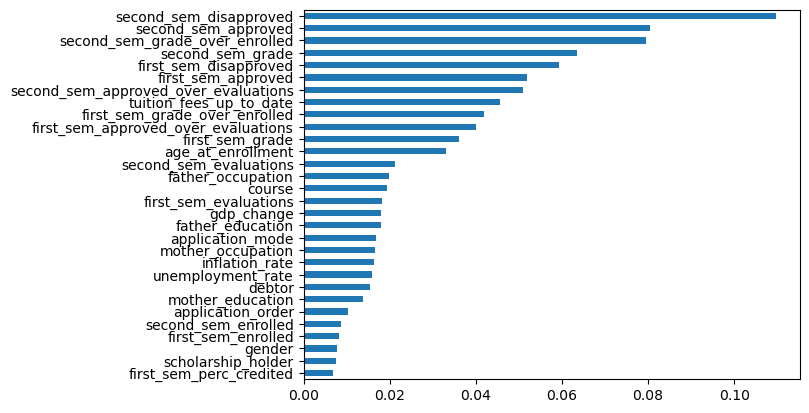

In [83]:
rfc_feat_imp.tail(30).plot.barh()

In [89]:
features_selected["rfc_feat_imp"] = rfc_feat_imp.loc[lambda x: x > 0.03].index.tolist()

In [98]:
print(
    *(
        f"The number of selected features by {k} is {len(v)}"
        for k, v in features_selected.items()
    ),
    sep="\n",
)

The number of selected features by variance_threshold is 28
The number of selected features by f_classif is 15
The number of selected features by mutual_inf is 15
The number of selected features by seq_feat_sel is 3
The number of selected features by rfc_feat_imp is 12


In [99]:
import pickle

with open("../data/features_selected.pkl", "wb") as f:
    pickle.dump(features_selected, f)